In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"TaskGraphs"));

In [2]:
using TaskGraphs

┌ Info: Precompiling TaskGraphs [6635cb54-791c-11e9-2805-8512ad3937f9]
└ @ Base loading.jl:1192


In [3]:
using CRCBS
using LightGraphs, MetaGraphs
using LinearAlgebra
using DataStructures
# using JuMP, MathOptInterface
# using Gurobi
using TOML
using Random

using GraphUtils
using DataFrames

In [5]:
include(joinpath(dirname(pathof(TaskGraphs)),"..","test","notebooks","render_tools.jl"));

# Experiments:

Generate 4 environments for all experiments

In [ ]:
# env_graphs = []
# envs = []
# num_obstacle_cells = 64
# for (i,n) in enumerate([2,4,8])
#     obs_w = Int(sqrt(num_obstacle_cells)/n)
#     env = construct_regular_factory_world(;
#         n_obstacles_x=n,
#         n_obstacles_y=n,
#         obs_width = [obs_w;obs_w],
#         obs_offset = [obs_w;obs_w],
#         env_pad = [1;1],
#         env_offset = [1,1],
#         env_scale = 1 # this is essentially the robot diameter
#     )
#     filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml")
#     open(filename,"w") do io
#         TOML.print(io,env)
#     end
#     # graphics_filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".svg")
#     # visualize_env(env) |> SVG(graphics_filename)
#     push!(envs, env)
# end

In [ ]:
i = 2;
set_default_plot_size(10cm,10cm);
filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml");
factory_env = read_env(filename)
env_graph = factory_env;
dist_matrix = get_dist_matrix(env_graph);

In [ ]:
problem_id = 65
results_filename = joinpath(EXPERIMENT_DIR,"assignment_solver/final_results",string(:full_solver),string("results",problem_id,".toml"))
toml_dict = TOML.parsefile(results_filename);
robot_paths = Vector{Vector{Int}}(toml_dict["robot_paths"]);
object_paths = Vector{Vector{Int}}(toml_dict["object_paths"]);
object_intervals = Vector{Vector{Int}}(toml_dict["object_intervals"]);

In [ ]:
p = visualize_env(factory_env,45;
        floor_color = LCHab(85,0,0),
        pickup_color= LCHab(85,0,0),#LCHab(75,80,140),
        dropoff_color=LCHab(85,0,0),#LCHab(75,80,50)
        robot_paths=robot_paths,
        object_paths=object_paths,
        object_intervals=object_intervals,
        colors_vec=map(i->LCHab(60,80,200),1:length(robot_paths)),
        show_inactive_objects=true,
        inactive_object_color="black",
        completed_object_color="black",
        active_object_colors=map(i->"black",object_paths),
        show_paths=false,
        rsize=4pt,
        osize=2pt,
)
p |> PDF(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics","env_graph.pdf"))

In [ ]:
# tf = maximum(map(p->length(p),robot_paths))
# set_default_plot_size(24cm,24cm)
# record_video(joinpath(VIDEO_DIR,string("replanning4.webm")),
#     t->render_paths(t,factory_env,robot_paths,object_paths;
#         object_intervals=object_intervals,
#         colors_vec=map(i->LCHab(60,80,200),1:length(robot_paths)),
#         project_idxs=project_idxs,
#         show_paths=false);tf=tf)

# Record Video

In [ ]:
# problem_id = 192
# # results_filename = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/meta_env_repaired/results",string(:full_solver),string("results",problem_id,".toml"))
# toml_dict = TOML.parsefile(results_filename);
# robot_paths = Vector{Vector{Int}}(toml_dict["robot_paths"]);
# object_paths = Vector{Vector{Int}}(toml_dict["object_paths"]);
# object_intervals = Vector{Vector{Int}}(toml_dict["object_intervals"]);
# tf = maximum(map(p->length(p),robot_paths))
# set_default_plot_size(24cm,24cm)
# record_video(joinpath(VIDEO_DIR,string("problem",problem_id,".webm")),
#     t->render_paths(t,robot_paths,object_paths;
#         object_intervals=object_intervals,
#         colors_vec=map(i->LCHab(60,80,200),1:length(robot_paths)),
#         show_paths=false);tf=tf)

# Load results into dataframes

In [ ]:
# N_problems = 384
# problem_dir = PROBLEM_DIR
# results_dir = RESULTS_DIR
# # results_dir = joinpath(EXPERIMENT_DIR,"adjacency_solver/results")
# config_df = construct_config_dataframe(problem_dir,N_problems);

In [ ]:
# df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)

# Display experimental results

In [ ]:
set_default_plot_size(28cm,12cm)

In [ ]:
# p1 = robots_vs_task_vs_time_box_plot(df_dict[:full_solver]; 
#     title="Full Algorithm")
# # p1 |> PDF("FullAlgorithm.pdf", 20cm, 12cm)
# # p1

In [ ]:
N_problems = 192
# problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport")
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport/final")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/meta_env_repaired/results")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);

In [ ]:
p1 = hstack(
    plot_collab_runtimes(
            df_dict[:assignment_only]; 
            title="assignment_only",big_font=12pt,small_font=10pt,
#             suppress_outliers=false
        ),
#     plot_collab_runtimes(
#             df_dict[:low_level_search_without_repair]; 
#             title="low_level_search_without_repair",big_font=12pt,small_font=10pt,
#             suppress_outliers=false
#         ),
    plot_collab_runtimes(
            df_dict[:full_solver][df_dict[:full_solver].feasible,:]; 
            title="full_solver",big_font=12pt,small_font=10pt,
#             suppress_outliers=false
        ),
    
    )

In [ ]:
df = df_dict[:full_solver]
@show sum(df.feasible)
@show sum(df.optimal)
@show df[df.optimal .== false,:].optimality_gap;
df = df_dict[:assignment_only]
@show sum(df.feasible)
@show sum(df.optimal)
@show df[df.optimal .== false,:].optimality_gap;

In [ ]:
function plot_collab_runtimes(df;
        title="Solution time by Number of Tasks (M) and ratio of tasks (task ratio )",
        yticks=[-1,0,1,2],
        ymin=-1.5,
        ymax=2.3,
        y_bounds=[0.01,100.0],
        big_font=14pt,
        small_font=12pt,
        xgroup=:TaskRatio,
        x=:M_string,
        y=:time,
        suppress_outliers=true,
        scale_y = Scale.y_log10(minvalue=y_bounds[1],maxvalue=y_bounds[2])
    )
    latex_fonts = Theme(major_label_font="CMU Serif", major_label_font_size=big_font,
                    minor_label_font="CMU Serif", minor_label_font_size=small_font,
                    key_title_font="CMU Serif", key_title_font_size=small_font,
                    key_label_font="CMU Serif", key_label_font_size=small_font)
    
    plot(df, xgroup=xgroup, x=x, y=y, color=x,
        Geom.subplot_grid(
            Geom.boxplot(;suppress_outliers=suppress_outliers),
            Coord.cartesian(; ymin=ymin, ymax=ymax),
            Guide.yticks(;ticks=yticks),
            Guide.xticks(;label=false),
            ),
        Guide.title(title),
        Guide.colorkey(title="num tasks", labels=["12","18","24"], pos=[0.1w,-0.32h]),
#         Scale.group_discrete(labels=M->string(M," Tasks"),levels=[1,2,3,4]),
        Guide.xlabel("task ratio"),
        Guide.ylabel("computation time (s)"),
        scale_y,
        latex_fonts
    )
end

In [ ]:
df = df_dict[:full_solver]
plot_collab_runtimes(
            df[df.total_CBS_iterations .> 0,:]; 
            title="cbs iterations",big_font=12pt,small_font=10pt,
#             num_robots=[24],
#             num_objects=[12,18,24],
#             yticks=[0,25,50,75,100],
            yticks=collect(0:250:2000),
            y_bounds=[1,maximum(df.total_CBS_iterations)],
            scale_y=Scale.y_continuous(),
            y=:total_CBS_iterations,
#             yticks=[0,25,50,75,100]
        )

In [ ]:
plot_collab_runtimes(
        df_dict[:full_solver]; 
        title="cbs iterations",big_font=12pt,small_font=10pt,
#         num_robots=[24],
#         num_objects=[12,18,24],
        yticks=[0,100,200,300,400],
#         yticks=collect(0:250:2000),
        y_bounds=[0.0,maximum(df_dict[:full_solver].max_CBS_iterations)],
        scale_y=Scale.y_continuous(),
        y=:max_CBS_iterations,
#         yticks=[0,25,50,75,100],
        suppress_outliers=false
    )

In [ ]:
@show maximum(df_dict[:full_solver].total_CBS_iterations)
@show maximum(df_dict[:full_solver].max_CBS_iterations);

In [ ]:
df = df_dict[:low_level_search_without_repair]
plot(
    layer(df_dict[:assignment_only][df.cost .< 1000,:], x=:problem_id, y=:cost,  Theme(default_color="red")),
    layer(df_dict[:low_level_search_without_repair][df.cost .< 1000,:], x=:problem_id, y=:cost, size=[5pt], Geom.point),
)

In [ ]:
p1 |> SVG("CollabResults.svg", 28cm, 12cm)

In [ ]:
df = df_dict[:full_solver]
hstack(
    plot_collab_counts(df;key=df.optimal,
        title="# Suboptimal vs. # Tasks x Task Ratio"),
    plot_collab_counts(df;key=df.feasible,
        title="# Infeasible vs. # Tasks x Task Ratio")
)

In [ ]:
@show sum(df_dict[:full_solver].feasible .== false)
@show sum(df_dict[:full_solver].optimal .== false)

In [ ]:
# N_problems = 384
# problem_dir = PROBLEM_DIR
# # results_dir = RESULTS_DIR
# results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
# df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
# preprocess_results!(df_dict1)
# p1 = hstack(
#     robots_vs_task_vs_time_box_plot(
#         df_dict1[:assignment_only]; 
#         title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
#     robots_vs_task_vs_time_box_plot(
#         df_dict1[:low_level_search_without_repair]; 
#         title="low Level Search (with Assignment MILP)",big_font=12pt,small_font=10pt)
#     )

In [ ]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict1)
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict2 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict2)
p1 = hstack(
    robots_vs_task_vs_time_box_plot(
        df_dict1[:assignment_only]; 
#         title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
        title="Assignment Only (assignment milp)",big_font=12pt,small_font=10pt),
    robots_vs_task_vs_time_box_plot(
        df_dict2[:assignment_only]; 
        title="Assignment Only (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt)
    )

In [ ]:
df = DataFrame(
    problem_id = df_dict1[:assignment_only].problem_id,
    time_assignment = df_dict1[:assignment_only].time, # optimal cost
    M = df_dict1[:assignment_only].M,
    N = df_dict1[:assignment_only].N,
)
df = join(df[df.time_assignment .< 90.0,:],
    df_dict2[:assignment_only][df_dict2[:assignment_only].time .< 90.0,[:problem_id, :time]],
    on = :problem_id,kind = :inner, makeunique=true);
begin df[!,:time_gap] = df.time .- df.time_assignment
    df
end
begin df[!,:relative_time_gap] = df.time_gap ./ df.time_assignment
    df
end
preprocess_results!(df)
maximum(df.time_gap)

In [ ]:
robots_vs_task_vs_time_box_plot(
        df; 
        title="Time Gap",big_font=12pt,small_font=10pt,
        y=:relative_time_gap,
        scale_y=Scale.y_continuous()
    )

In [ ]:
@show sum(df.relative_time_gap) / nrow(df)
@show sort(df.relative_time_gap)[167]

In [ ]:
p1 |> SVG("AssignmentHeadToHead.svg", 28cm, 12cm)

In [ ]:
# set_default_plot_size(20cm,9cm)
# p3 = robots_vs_task_vs_time_box_plot(
#     df_dict[:low_level_search_with_repair];title=nothing,yticks=[-1,0,1],ymin=-1.5,ymax=0.2)

# Plot runtime results in box plots across collaborative tasks

In [ ]:
N_problems = 192
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport/final")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/meta_env_repaired/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);

mode_list = [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
# tmin = minimum(map(MODE->minimum(df_dict1[MODE].time),mode_list))
tmin = 0.06
tmax = 250
base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
for (filename, title, draw_labels,t_lo,t_hi) in [
        (:assignment_only,"",true,tmin,tmax),
        (:low_level_search_without_repair,"",true,tmin,tmax),
        (:full_solver,"",true,tmin,tmax)
        ]

    open(joinpath(base_dir,string(filename,".tex")),"w") do io
        gp = get_runtime_box_plot(
            df_dict[filename];
            ymin=t_lo,
            ymax=t_hi,
            ytick=[0.1,1,10,100],
            title=title,
            obj=:time,
            outer_key=:TaskRatio,
            inner_key=:M,
            outer_range=1:1:4,
            inner_range=12:6:24,
            inner_sym="m",
            outer_sym="ratio",
            ylabel_shift="-6pt",
            xtick=[12,18,24],
            title_shift=[1.8,2.55],
            draw_labels=draw_labels,
            legend_draw="black",
            legend_fill="white",
        )
        print_tex(io, gp)
    end
end

# CBS Total Iterations

In [ ]:
N_problems = 192
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport/final")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/meta_env_repaired/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);

base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
filename = :CBS_count
open(joinpath(base_dir,string(filename,".tex")),"w") do io
    gp = get_runtime_box_plot(
        df_dict[:full_solver];
        ymin=0,
        ymax=550,
        ytick=[0,100,200,300,400,500],
        ymode="normal",
        ylabel="num. iterations",
        title="",
        obj=:total_CBS_iterations,
        outer_key=:TaskRatio,
        inner_key=:M,
        outer_range=1:1:4,
        inner_range=12:6:24,
        inner_sym="m",
        outer_sym="ratio",
        xtick=[12,18,24],
        title_shift=[1.8,2.55],
        draw_labels=true,
    )
    print_tex(io, gp)
end

# Plot Relative Optimality gap between optimal solver and greedy algorithm

In [ ]:
N_problems = 192
# problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/non_zero_collect_time/results")
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport/final")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/final/meta_env_repaired/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);
df1 = df_dict[:assignment_only]
# results_dir = joinpath(EXPERIMENT_DIR,"greedy_assignment/non_zero_collect_time/results")
results_dir = joinpath(EXPERIMENT_DIR,"greedy_assignment/final/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);
df2 = df_dict[:assignment_only];


In [ ]:
# df = join(df1,df2,on = :problem_id,kind = :inner, makeunique=true);
df = DataFrame(
    problem_id = df1.problem_id,
    cost1 = df1.cost, # optimal cost
    M = df1.M,
    TaskRatio = df1.TaskRatio
)
df = join(df,df2,on = :problem_id,kind = :inner, makeunique=true);
begin df[!,:optimality_gap] = df.cost .- df.cost1
    df
end
begin df[!,:relative_gap] = df.optimality_gap ./ df.cost1
    df
end

base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
open(joinpath(base_dir,"baseline_cost_comparison.tex"),"w") do io
    gp = get_runtime_box_plot(
        df;
        ymin=-0.1,
        ymax=2.0,
        ymode="normal",
        ylabel="relative optimality gap",
        title="",
        obj=:relative_gap,
        outer_key=:TaskRatio,
        inner_key=:M,
        outer_range=1:1:4,
        inner_range=12:6:24,
        inner_sym="m",
        outer_sym="ratio",
        xtick=[12,18,24],
        ytick=[0.0,0.5,1.0,1.5,2.0],
        title_shift=[1.8,2.55],
#         draw_labels=draw_labels
    )
    print_tex(io, gp)
end

# Compare assignment milp to sparse adjacency milp

In [ ]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver","results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_results!(df_dict);
df1 = df_dict[:assignment_only]
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_results!(df_dict);
df2 = df_dict[:assignment_only];
df = DataFrame(
    problem_id = df1.problem_id,
    time_assignment = df1.time, # optimal cost
    M = df1.M,
    N = df1.N,
)
df = join(df[df.time_assignment .< 100.0,:],
    df2[df2.time .< 100.0,[:problem_id, :time]],
    on = :problem_id,kind = :inner, makeunique=true);
begin df[!,:time_gap] = df.time .- df.time_assignment
    df
end
begin df[!,:relative_time_gap] = df.time_gap ./ df.time_assignment
    df
end
preprocess_results!(df);

In [ ]:
tmin = min(minimum(df1.time),minimum(df2.time))
base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
for (df, filename, title,draw_labels) in [
        (df,"assignment_milp_runtime_factor","",true),
#         (df2,"sparse_adjacency_milp_single_tasks_runtime","",false),
        ]

    open(joinpath(base_dir,string(filename,".tex")),"w") do io
        gp = get_runtime_box_plot(
            df;
            ymin=-10,
            ymax=10,
            ylabel="relative solver time",
            title=title,
            obj=:relative_time_gap,
            outer_key=:M,
            inner_key=:N,
            outer_range=10:10:60,
            inner_range=10:10:30,
            inner_sym="n",
            outer_sym="m",
            xtick=[10,20,30],
            draw_labels=draw_labels,
            width="2.75cm",
            ymode="normal"
        )
        print_tex(io, gp)
    end
end

# For original ICRA paper

In [ ]:
# # titles = Dict(
# #     :full_solver => "Runtime of Full \\PCTAPF{} Solver",
# #     :assignment_only => "Runtime of Task Assignment MILP Solver",
# #     :low_level_search_with_repair => "Runtime of \\LevelThreeLong{}",
# #     :low_level_search_without_repair => "Runtime of \\LevelThreeLong{}",
# # )
# titles = Dict(
#     :full_solver => "Experimental Results (Runtime)",
#     :assignment_only => "",
#     :low_level_search_with_repair => "",
#     :low_level_search_without_repair => "",
# )
# for MODE in [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
#     gp = get_runtime_box_plot(df_dict[MODE];ymin=tmin,title=titles[MODE])
# #     open(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics",string(MODE,".tex")),"w") do io
#     open(string(MODE,".tex"),"w") do io
#         print_tex(io, gp)
#     end
# end

In [56]:
N_problems = 384
problem_dir = joinpath(PROBLEM_DIR)
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
# results_dir = joinpath(EXPERIMENT_DIR,"results")
# results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/final_results")
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/cbs_fix_results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_results!(df_dict);
# df_dict[:full_solver].time[df_dict[:full_solver].time .> 100] .= 100.0

mode_list = [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
# tmin = minimum(map(MODE->minimum(df_dict1[MODE].time),mode_list))
tmin = 0.06
tmax = 250
base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results/single_project/test")
for (filename, title, draw_labels,t_lo,t_hi) in [
        (:full_solver,"Experimental Results (Runtime)",true,tmin,tmax),
        (:assignment_only,"",true,tmin,tmax),
        (:low_level_search_without_repair,"",true,tmin,tmax),
        (:low_level_search_with_repair,"",true,tmin,tmax),
        ]

    open(joinpath(base_dir,string(filename,".tex")),"w") do io
        gp = get_runtime_box_plot(
            df_dict[filename];
            # ymin=t_lo,
            # ymax=t_hi,
            # ytick=[0.1,1,10,100],
            # title=title,
            # obj=:time,
            # outer_key=:M,
            # inner_key=:N,
            # outer_range=10:10:60,
            # inner_range=10:10:40,
            # inner_sym="n",
            # outer_sym="m",
            # ylabel_shift="-6pt",
            # xtick=collect(10:10:40),
            # title_shift=[1.8,2.55],
            # draw_labels=draw_labels,
            width="\\plotarraywidth",
            height="\\plotarrayheight",
            legend_draw="none",
            legend_fill="white",
        )
        print_tex(io, gp)
    end
end
for (dict_id,filename, title, draw_labels,t_lo,t_hi) in [
        (:full_solver,:max_CBS_iterations,"",true,-3,103),
        ]

    open(joinpath(base_dir,string(filename,".tex")),"w") do io
        gp = get_runtime_box_plot(
            df_dict[dict_id];
            ymin=t_lo,
            ymax=t_hi,
            ytick=[0,25,50,75,100],
            # title=title,
            obj=:max_CBS_iterations,
            ymode="normal",
            ylabel="max CBS iterations",
            # outer_key=:M,
            # inner_key=:N,
            # outer_range=10:10:60,
            # inner_range=10:10:40,
            # inner_sym="n",
            # outer_sym="m",
            # ylabel_shift="-6pt",
            # xtick=collect(10:10:40),
            # title_shift=[1.8,2.55],
            # draw_labels=draw_labels,
            width="\\plotarraywidth",
            height="\\plotarrayheight",
            legend_draw="none",
            legend_fill="white",
        )
        print_tex(io, gp)
    end
end

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


In [45]:
df2 = df_dict[:full_solver]
df1 = df_dict[:assignment_only];
df3 = df_dict[:low_level_search_without_repair];

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


In [44]:
N_problems = 384
problem_dir = joinpath(PROBLEM_DIR)
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
# results_dir = joinpath(EXPERIMENT_DIR,"results")
# results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/final_results")
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/cbs_fix_results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_results!(df_dict);

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


In [69]:
sum(df2.feasible)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


384

In [46]:
# instances of zero optimality gap that are not actually optimal
optimality_gaps = df1.optimality_gap .+ df2.cost .- df1.cost
sum(optimality_gaps.*df2.optimal)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


0

In [89]:
sum((optimality_gaps .> 0).*(df1.time .< 100))

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


9

In [118]:
100.0*[i for i in (optimality_gaps./df2.cost).*(df1.optimal).*(df2.time .< 120).*(df2.max_CBS_iterations .< 100) if i != 0]

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


3-element Array{Int64,1}:
 8
 2
 1

In [51]:
# max CBS iterations across all problem instances
maximum(df2.max_CBS_iterations)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


101

In [68]:
# number of problem instances on which max_CBS_iterations > 0
sum((df2.max_CBS_iterations .>= 100) .* df1.optimal)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


2

In [67]:
df2[df2.max_CBS_iterations .>= 100,:].optimality_gap

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


2-element Array{Int64,1}:
  0
 16

In [61]:
sum((df1.time .>= 100) .* .~df2.optimal)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


40

In [55]:
# max runtime for single iteration of ISPS
maximum(df3.time)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


0.577353724

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│   /home/kylebrown/.julia/dev/TaskGraphs/src/path_planning.jl
└ @ Revise /home/kylebrown/.julia/packages/Revise/0KQ7U/src/Revise.jl:622


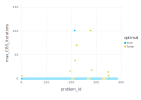

In [58]:
# scatter plot of CBS iterations per problem id
plot(df2, x=:problem_id, y=:max_CBS_iterations, color=:optimal)